# Helper functions

In [75]:
from IPython.display import Image
import os
import shutil
from os import listdir
from os.path import isfile, join

In [76]:
def create_empty_dir(dir):
    """
    Creates a directory.
    If the fodler exists, it clears it's content by recreating it.
    @param: dir - folder's path string
    """
    if os.path.isdir(dir):
        shutil.rmtree(dir)    
    os.mkdir(dir)

In [77]:
def get_file_list(dir, ext=None):
    """
    Returns the file list of the given folder.

    @param dir - folder's path string
    @param ext - extensions filter list. It could be str or a list
    @return list of files in the folder
    """
    # single extension
    if type(ext) == str:
        return [join(frame_dir, f) for f in listdir(frame_dir) if isfile(join(frame_dir, f)) and f.split(".")[-1] == ext]

    # extension list
    if type(ext) == list:
        return [join(frame_dir, f) for f in listdir(frame_dir) if isfile(join(frame_dir, f)) and f.split(".")[-1] in ext]
    
    # no extensions
    return [join(frame_dir, f) for f in listdir(frame_dir) if isfile(join(frame_dir, f))]

# Darknet

In [ ]:
# based on https://colab.research.google.com/drive/1_GdoqCJWXsChrOiY8sZMr_zbr_fH-0Fg?usp=sharing#scrollTo=GQQrAMdXN22a
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# enable GPU and OPENCV in the makefile
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# check CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# build darknet library
!make

# Copy custom files

In [ ]:
# manully annotated smaller dataset (50 images)
# !unzip /content/drive/My\ Drive/20200722/task_garbage_detection_2-2020_07_23_13_39_54-yolo-1.1.zip -d /content/darknet/data/

# generated and manually fixed dataset (322 images)
!unzip /content/drive/My\ Drive/20200722/task_garbage_det_fps_15_img_annot_322-2020_07_24_13_19_02-yolo-1.1.zip -d /content/darknet/data/

In [29]:
!cp /content/drive/My\ Drive/20200722/yolov4-custom.cfg ./cfg/

In [32]:
objd_path = 'data/obj.data'
cfg_path = 'cfg/yolov4-custom.cfg'

In [ ]:
!cat {data_path}
#!cat {cfg_path}

# Train model on custom dataset

In [ ]:
# download COCO dataset
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [30]:
weight_path = 'yolov4.conv.137'

In [ ]:
!./darknet detector train {objd_path} {cfg_path} {weight_path} -dont_show -map

In [ ]:
Image('chart.png')

## Store weights on drive

In [24]:
from distutils.dir_util import copy_tree

In [ ]:
backup_path = '/content/drive/My Drive/20200726/yolo_backup'
orig_backup_dir = '/content/darknet/backup'

create_empty_dir(backup_path)
copy_tree(orig_backup_dir, backup_path)

# Detections

### Import existing model

In [33]:
weight_path = '/content/drive/My\ Drive/20200724/yolo_backup/yolov4-custom_best.weights'

## Run detection on a single image

In [34]:
img_path = '/content/darknet/data/obj_train_data/fps_15_frame_0034.jpg'

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg {weight_path} {img_path} \
        -thresh 0.1 -dont_show

Image('predictions.jpg')

## Run detection on a video

In [41]:
video_path = '/content/drive/My\ Drive/20200724/VID_20200722_115436_stabiilizo_annot.mp4'
video_out = '/content/results.avi'

In [ ]:
!./darknet detector demo {data_path} {cfg_path} {weight_path} \
    -dont_show {video_path} -i 0 -out_filename {video_out} -thresh 0.1

In [ ]:
!cp ./results.avi /content/drive/My\ Drive/20200722/

# Generate annotations

## Convert Video to frames and create frame_list.txt 

In [ ]:
# Video to frames
frame_dir = '/content/frames'
input_video = '/content/drive/My\ Drive/20200724/VID_20200722_115436_stabiilizo_annot.mp4'
create_empty_dir(frame_dir)

fps = 15
frames_name = os.path.join(frame_dir, "fps_{}_frame_%04d.jpg".format(fps))
!ffmpeg -i {input_video} -vf fps={fps} -qscale:v 2 {frames_name}

In [ ]:
frame_dir = '/content/frames'
frame_list_file = '/content/frames_list.txt'

frame_list = get_file_list(frame_list_file, ext='jpg')
print("Number of frames: {}".format(len(frame_list)))

# write frame list to file
with open(frame_list_file, 'w') as f:
    for frame_path in frame_list:
        f.write(frame_path + "\n")

## Generate json with the trained model

In [66]:
weight_path = '/content/drive/My\ Drive/20200724/yolo_backup/yolov4-custom_best.weights'
output_json_path = 'content/result.json'

In [ ]:
!./darknet detector test {data_path} {cfg_path} {weight_path} -dont_show -out /content/result.json -ext_output \
    <{frame_list_file}> /content/result.txt -thresh 0.1

## Convert JSON to Pascal VOC

In [ ]:
!pip install pascal-voc-writer

In [72]:
import json
from pprint import pprint
from PIL import Image
from pascal_voc_writer import Writer

In [73]:
with open('/content/result.json') as f:
    data = json.load(f)

In [74]:
# clear folder if exsists
annot_dir = '/content/pascal_voc'
create_empty_dir(annot_dir)

for det_result in data:
    # pprint(image_res)
    img_path = det_result['filename']
    img = Image.open(img_path)
    width, height = img.size

    # Writer(path, width, height)
    writer = Writer(img_path, width, height)

    for obj in det_result['objects']:
        bb_x_center = obj['relative_coordinates']['center_x']
        bb_y_center = obj['relative_coordinates']['center_y']
        
        bb_width = obj['relative_coordinates']['width']
        bb_height = obj['relative_coordinates']['height']

        xmin = int((bb_x_center - bb_width/2) * width)
        xmax = int((bb_x_center + bb_width/2) * width)
        
        ymin = int((bb_y_center - bb_height/2) * height)
        ymax = int((bb_y_center + bb_height/2) * height)

        # ::addObject(name, xmin, ymin, xmax, ymax)
        writer.addObject(obj['name'], xmin, ymin, xmax, ymax)

    #image name without extension
    xml_name = img_path.split("/")[-1].split('.')[0] + ".xml"
    xml_path = os.path.join(annot_dir, xml_name)
    writer.save(xml_path)
    # print(xml_name)

In [ ]:
!cd /content/; zip frames/pascal_voc.zip pascal_voc/*
!cd /content/; zip garbage_det_fps_15_img_annot_322.zip frames/*

In [ ]:
!cp /content/garbage_det_fps_15_img_annot_322.zip /content/drive/My\ Drive/20200722

# Pytorch

In [ ]:
%cd /content/
!git clone --depth 1 https://github.com/Tianxiaomo/pytorch-YOLOv4

In [ ]:
# !pip install -U setuptools
# !apt install enchant
# !pip install pyenchant

In [ ]:
# !pip3 install skimage
# !pip install scikit-image
!pip install tensorboardX

In [ ]:
%cd /content/pytorch-YOLOv4/
!pip install -r requirements.txt

In [ ]:
# !python train.py -g 0 -dir /content/pytorch-YOLOv4/data

In [ ]:
%cd /content/pytorch-YOLOv4

In [ ]:
_data_path = '/content/darknet/data/obj.data'
_cfg_path = '/content/darknet/cfg/yolov4-custom.cfg'
_weight_path = '/content/drive/My\ Drive/20200722/yolow_backup/yolov4-custom_best.weights'
_img_path = '/content/fps_5_frame_0002.jpg'

In [ ]:
!python demo.py -cfgfile {_cfg_path} -weightfile {_weight_path} -imgfile {_img_path}

In [ ]:
# !cat /content/pytorch-YOLOv4/data/train.txt

# Tensorflow

In [ ]:
_data_path = '/content/darknet/data/obj.data'
_cfg_path = '/content/darknet/cfg/yolov4-custom.cfg'
_weight_path = '/content/drive/My\ Drive/20200722/yolow_backup/yolov4-custom_best.weights'
_img_path = '/content/fps_5_frame_0002.jpg'

In [ ]:
%cd /content/

In [ ]:
# !pip install --no-cache-dir https://github.com/sicara/tf2-yolov4/archive/master.zip

In [ ]:
!git clone https://github.com/sicara/tf2-yolov4/

In [ ]:
!cd tf2-yolov4/; pip install -r requirements-dev.txt

In [ ]:
# !pip uninstall https://github.com/sicara/tf2-yolov4/archive/master.zip

In [ ]:
%cd /content/tf2-yolov4/
!pip install .

In [ ]:
!git pull

In [ ]:
# !convert-darknet-weights _weight_path -o yolov4.h5
# !ls -la ./yolov4.h5
# !convert-darknet-weights --help
# !convert-darknet-weights {_weight_path} -o yolov4.h5

In [ ]:
!cd /content/tf2-yolov4/tf2_yolov4/tools/; python3 convert_darknet_weights.py {_weight_path} -o yolov4.h5 --num_classes 5

In [ ]:
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4

from tf2_yolov4.tools.convert_darknet_weights import convert_darknet_weights as cdw
from tf2_yolov4.tools.weights import load_darknet_weights_in_yolo
import numpy as np

import tensorflow as tf

In [ ]:
num_classes = 5
HEIGHT, WIDTH = 416, 416
INPUT_SHAPE = (HEIGHT, WIDTH, 3)
output_weights_path = '/content/yolov4.h5'
_weight_path='/content/drive/My Drive/20200722/yolow_backup/yolov4-custom_best.weights'

In [ ]:
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4

# from tf2_yolov4.tools.convert_darknet_weights import convert_darknet_weights as cdw
from tf2_yolov4.tools.weights import load_darknet_weights_in_yolo
import numpy as np

model = YOLOv4(
        input_shape=INPUT_SHAPE, num_classes=num_classes, anchors=YOLOV4_ANCHORS,
        weights=None,
        training=False
)

model.predict(np.random.random((1, *INPUT_SHAPE)))
model = load_darknet_weights_in_yolo(model, darknet_weights_path=_weight_path)
model.save(output_weights_path)

In [ ]:
print(model.summary())

In [ ]:
# from IPython.display import Image
# img_path = '/content/fps_5_frame_0008.jpg'
# Image(img_path)

In [ ]:
model_det = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=5,
    training=False,
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
    weights='/content/yolov4.h5'
)

# model_det.load_weights("/content/yolov4.h5")
model_det.summary()

In [ ]:
image = tf.io.read_file(img_path)
image = tf.image.decode_image(image)
image = tf.image.resize(image, (HEIGHT, WIDTH))
images = tf.expand_dims(image, axis=0) / 255.0

In [ ]:
boxes, scores, classes, valid_detections = model.predict(images)
print(valid_detections)

[0]


In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot_results(pil_img, boxes, scores, classes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()

    for (xmin, ymin, xmax, ymax), score, cl in zip(boxes.tolist(), scores.tolist(), classes.tolist()):
        if score > 0:
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=COLORS[cl % 6], linewidth=3))
          text = f'{CLASSES[cl]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

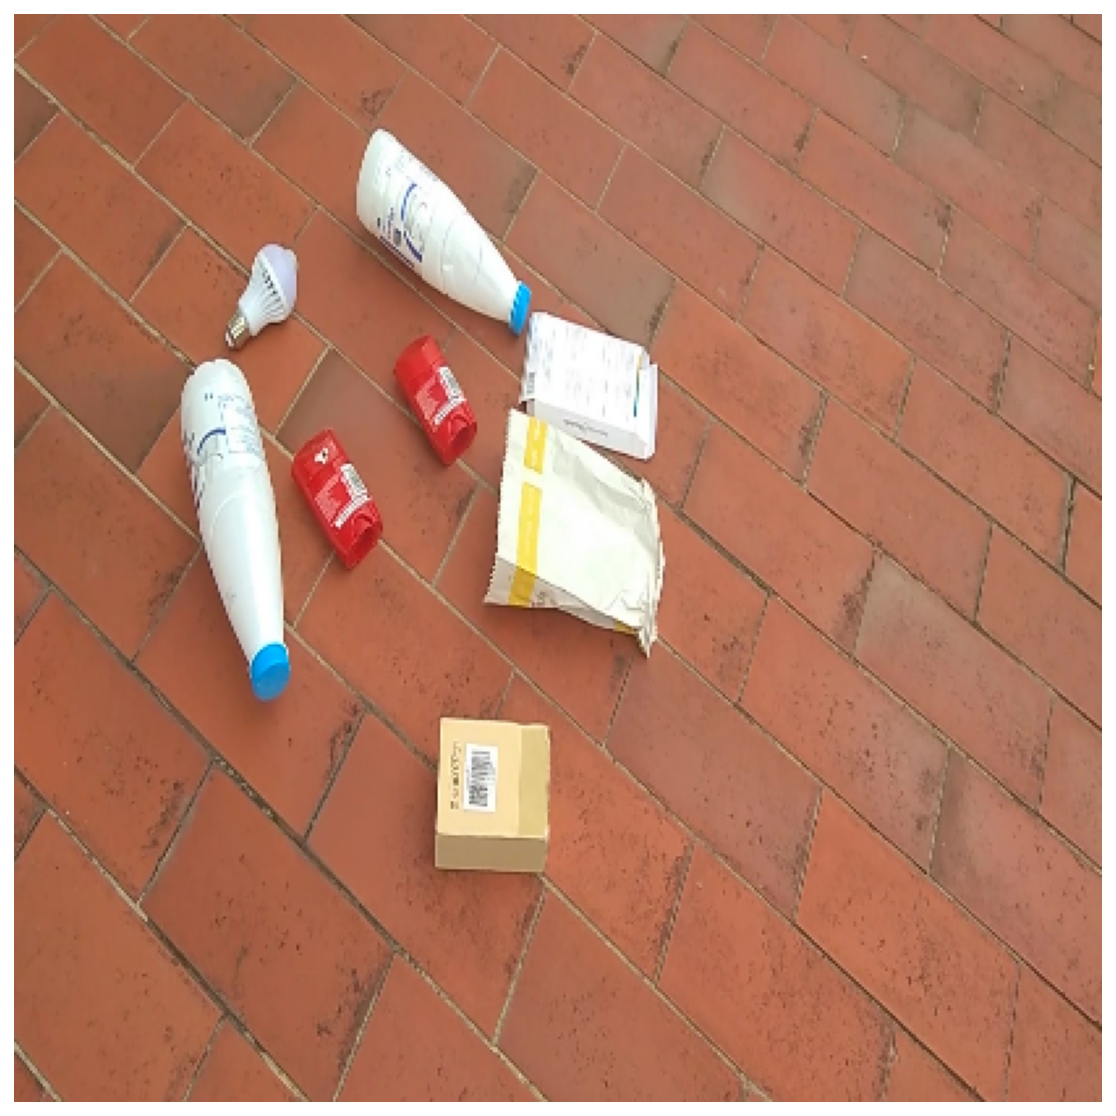

In [ ]:
plot_results(
    images[0],
    boxes[0] * [WIDTH, HEIGHT, WIDTH, HEIGHT],
    scores[0],
    classes[0].astype(int),
)

In [ ]:
boxes, scores, classes, valid_detections = model.predict(images)

# Yolov3-tf2

In [ ]:
# %cd /content/
!git clone https://github.com/zzh8829/yolov3-tf2

/content
Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 380, done.
remote: Total 380 (delta 0), reused 0 (delta 0), pack-reused 380
Receiving objects: 100% (380/380), 4.22 MiB | 2.16 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [ ]:
!cd /content/yolov3-tf2/; pip install .

In [ ]:
from yolov3_tf2.models import YoloV3, YoloV3Tiny


In [ ]:
 yolo = YoloV3(classes=5)